In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

f:\Generative_AI\Projects\LangGraph-End_to_End\venv\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq

embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

llm=ChatGroq(model_name="Gemma2-9b-It")

llm.invoke("hello how are you?")

AIMessage(content="As a large language model, I don't have feelings or experiences like humans do. However, I'm here and ready to assist you with any questions or tasks you may have!\n\nHow can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 14, 'total_tokens': 63, 'completion_time': 0.089090909, 'prompt_time': 0.001898806, 'queue_time': 0.230659783, 'total_time': 0.090989715}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-e216ba6b-a8b5-4856-b1e6-1fe5776602d1-0', usage_metadata={'input_tokens': 14, 'output_tokens': 49, 'total_tokens': 63})

In [5]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [6]:
WebBaseLoader(url).load()[0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [7]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [8]:
# Spliting the docs into chunks

docs_list=[item for sublist in docs for item in sublist]

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

doc_splits=text_splitter.split_documents(docs_list)

In [9]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings)

retriever=vectorstore.as_retriever()

In [10]:
retriever_tool= create_retriever_tool(retriever,
                                      "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

tools= [retriever_tool] 

# Tool Node for LanGgraph
retrieve=  ToolNode([retriever_tool])

## Code Breakdown:
**class** AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
This code defines a class AgentState that is a TypedDict, which is a special kind of dictionary with fixed keys and value types, used to provide better type safety and autocompletion in Python.

Here’s a breakdown of each part:

1. ### AgentState(TypedDict)
TypedDict: This is a special class provided by typing that allows you to define dictionaries where each key has a fixed type. The dictionary keys are usually predefined, and each key must have a specified type.

AgentState here is a subclass of TypedDict, meaning AgentState will represent a dictionary where the types of its values are enforced.

Example:

agent_state = AgentState(messages=["Message 1", "Message 2"])  # This would be valid.

2. ### messages: Annotated[Sequence[BaseMessage], add_messages]
**messages:** This is a key in the AgentState dictionary. It holds a sequence (like a list or tuple) of BaseMessage objects.

**Annotated[...]**: Annotated is used to attach additional metadata or annotations to the type. It’s a way to add extra information to the type system without affecting the actual type. In this case, it provides metadata for the messages field.

The **Annotated** wrapper allows you to define a type and also include additional information that might be used by tools like static analyzers or for other purposes like validation.
**Sequence[BaseMessage]:** This indicates that messages should be a sequence (e.g., a list or tuple) of BaseMessage objects.

**BaseMessage** is likely a class that represents a message in the context of your program. It could have fields like content, sender, timestamp, etc.
**add_messages:** This is a special annotation (or metadata) that likely refers to some function or constant that’s being added as additional context. The specific role of add_messages will depend on how it's defined elsewhere in the codebase.

**add_messages** could be a function, validator, or modifier that helps manage or process the messages in some way, but it's not directly modifying the type of messages. It's simply metadata for the type checker or other parts of the system.

For example, if add_messages were a function, it could be used in a custom decorator, validation system, or simply as an indication of how to handle messages.

### Putting It All Together:
**AgentState** is a dictionary where one of the keys, messages, is specifically typed to be a **sequence of BaseMessage** objects. The sequence is annotated with **add_messages**, which provides additional metadata but doesn’t affect the type directly.

**Example of AgentState usage:**

from typing import TypedDict, Sequence
from typing_extensions import Annotated

class BaseMessage:
    def __init__(self, content: str):
        self.content = content

#Defining the `AgentState` TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "add_messages"]

#Example usage
message1 = BaseMessage("Hello, world!")
message2 = BaseMessage("How are you?")
state = AgentState(messages=[message1, message2])

print(state)
In the above code:

AgentState is a dictionary with a messages field that is a sequence of BaseMessage objects.
add_messages is metadata associated with the messages field, which can help guide the usage or interpretation of the data.
### Summary:
AgentState is a dictionary where the messages key holds a sequence of BaseMessage objects.
Annotated[Sequence[BaseMessage], add_messages] means that messages is a sequence of BaseMessage objects with additional metadata (add_messages).
The annotation add_messages provides extra context or metadata that doesn't alter the type directly but can be used for purposes like validation or other system-specific behavior.
Let me know if you'd like further clarification on any part of this! 😊

In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [12]:
# Agent Function
def agent(state: AgentState):
    print("---CALL AGENT---")
    messages=state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
        chain = prompt | llm
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool= llm.bind_tools(tools)    
        response= llm_with_tool.invoke(messages)
        return {"messages": [response]}

In [13]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [14]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [15]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages= state['messages']
    
    question= messages[0].content
    
    last_messages= messages[-1]
    docs= last_messages.content
    
    prompt= hub.pull('rlm/rag-prompt')
    rag_chain= prompt | llm
    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    return {"messages": [response]}

In [16]:
from langchain_core.messages import  HumanMessage

def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [17]:
# LangGraph

workflow= StateGraph(AgentState)

# Nodes
workflow.add_node("AI Agent", agent)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewritter", rewrite)

# Edges
workflow.add_edge(START, "AI Agent")
workflow.add_conditional_edges("AI Agent",
                               tools_condition,
                               {"tools":"Vector_Retriever",
                                END:END})
workflow.add_conditional_edges("Vector_Retriever",
                               grade_documents,
                               {"generator": "Output_Generator",
                                "rewriter": "Query_Rewritter"})
workflow.add_edge("Query_Rewritter", "AI Agent")
workflow.add_edge("Output_Generator", END)

app=workflow.compile()

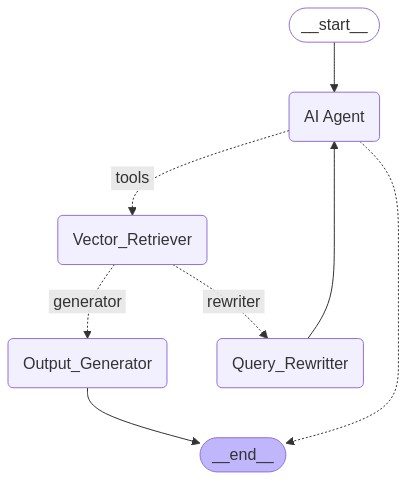

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---
this is my response:content='An autonomous agent is a system where a large language model (LLM) acts as the "brain".  \n\nIt is complemented by other components like planning and self-reflection to solve problems and act independently.  LLM-powered autonomous agents can be seen as powerful general problem solvers. \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 335, 'total_tokens': 397, 'completion_time': 0.112727273, 'prompt_time': 0.014050394, 'queue_time': 0.23305504500000002, 'total_time': 0.126777667}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-8be65474-8cf0-46e1-9522-f3d1ef8568f7-0' usage_metadata={'input_tokens': 335, 'output_tokens': 62, 'total_tokens': 397}


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='36e6b047-befb-466b-b1f4-71553d557843'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hzs2', 'function': {'arguments': '{"query":"Autonomous Agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1039, 'total_tokens': 1124, 'completion_time': 0.154545455, 'prompt_time': 0.036254282, 'queue_time': 0.233465149, 'total_time': 0.190799737}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a72d6256-47e1-491d-874d-4a41ca02311c-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Autonomous Agent'}, 'id': 'call_hzs2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1039, 'output_tokens': 85, 'total_tokens': 1124}),
  ToolMessage(content='Posts\n\n\n\n\nArchive\n\n\n\n\nSear

In [20]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

---CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---
this is my response:content="Prompt engineering in LangChain involves designing effective instructions (prompts) to guide the behavior of a large language model (LLM) agent. \n\nThis is crucial because LLMs need clear guidance to perform tasks and generate desired outputs. \nBy carefully crafting prompts, developers can leverage the LLM's capabilities to build sophisticated agents capable of interacting with tools and accomplishing complex goals. \n" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 383, 'total_tokens': 464, 'completion_time': 0.147272727, 'prompt_time': 0.014366363, 'queue_time': 0.241540168, 'total_time': 0.16163909}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-89b3fceb-fa29-4ff0-8e37-27f6d0a3130c-0' usage_metadata={'input_tokens': 383, 'output_tokens': 81, 'total_tokens': 464}


{'messages': [HumanMessage(content='what is a prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='539cc754-782e-4dac-aad1-8a8037dd7720'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wmry', 'function': {'arguments': '{"query":"prompt engineering langchain agents"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1048, 'total_tokens': 1136, 'completion_time': 0.16, 'prompt_time': 0.036604551, 'queue_time': 0.23314049000000003, 'total_time': 0.196604551}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-47488b4e-47aa-4b11-8378-96cdab2d1012-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'prompt engineering langchain agents'}, 'id': 'call_wmry', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1048, 'output_tokens': 88

In [21]:
app.invoke({"messages":["what is capital of india?"]})

---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='a5d86391-4e63-44fa-89db-a2494fad4137'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6ppr', 'function': {'arguments': '{"query":"Capital of India"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1039, 'total_tokens': 1124, 'completion_time': 0.154545455, 'prompt_time': 0.036316773, 'queue_time': 0.239232348, 'total_time': 0.190862228}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da3b8eb3-56ea-4210-9821-b3bc8bd912da-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Capital of India'}, 'id': 'call_6ppr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1039, 'output_tokens': 85, 'total_tokens': 1124}),
  ToolMessage(content='route inquiries to the best suitable e